<a href="https://colab.research.google.com/github/vondervish/Emotion_Detection_Roberta/blob/main/Assignment_8_LLama_Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'indianred'>**Multilabel Classification of Emotion Dataset using Llama-Base model** </font>

In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


# <font color = 'indianred'> **1. Setting up the Environment** </font>

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq

    basepath = '/content/drive/MyDrive/Data'

else:
    basepath = '/C:/Users/Vishu/Downloads/Fall_2024/App_NLP'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
ERROR: pip'

<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata

In [ ]:
set_seed(42)

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vondervish (vondervish-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'emotion-detection-bert-fall-2024'
model_folder = base_folder/'Models/Emotion_detection_Llama_languagehead_fall_2024'

In [ ]:
model_folder.mkdir(exist_ok=True, parents = True)

In [ ]:
model_folder

PosixPath('/content/drive/MyDrive/Data/Models/Emotion_detection_Llama_languagehead_fall_2024')

# <font color = 'indianred'> **2. Load Data set**

In [ ]:
train_dataset = data_folder/'train.csv'
test_dataset = data_folder/'test.csv'

In [ ]:
from datasets import load_dataset

# Load the train and test datasets from CSV files
train_dataset = load_dataset('csv', data_files={'train': str(data_folder / 'train.csv')})['train']
test_dataset = load_dataset('csv', data_files={'test': str(data_folder / 'test.csv')})['test']

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 7724
})

In [ ]:
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>

In [ ]:
# Split train_dataset into a new train and validation set
train_val_split = train_dataset.train_test_split(test_size=0.2, seed=42)

# Assign the splits to new variables
train_dataset = train_val_split['train']
valid_dataset = train_val_split['test']

In [ ]:
print(type(train_dataset))  # Expected to be `datasets.Dataset`
print(type(valid_dataset))  # Expected to be `datasets.Dataset`
print(type(test_dataset))   # Expected to be `datasets.Dataset`

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
train_val_dataset= DatasetDict(
    {"train": train_dataset, "valid": valid_dataset})

In [ ]:
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1545
    })
})

In [ ]:
# Function to reformat a single dataset
def reformat_dataset(dataset):
    # Map each row to extract the label and keep only relevant columns
    def format_row(row):
        # Collect emotions where the value is 1
        labels = [emotion for emotion in class_names if row[emotion] == 1]
        return {"text": row["Tweet"], "label": labels}

    # Apply the transformation
    return dataset.map(format_row, remove_columns=["ID"] + class_names)

# Reformat both train and validation datasets separately
train_val_dataset = DatasetDict({
    "train": reformat_dataset(train_val_dataset["train"]),
    "valid": reformat_dataset(train_val_dataset["valid"])
})

# Display a sample from the train dataset
print(train_val_dataset["train"][0])

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

{'Tweet': 'Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry', 'text': 'Does anyone know, are both Sims in a dual sim phone both locked to the same network! #worry', 'label': ['fear', 'pessimism', 'sadness']}


In [ ]:
# Define columns to keep
selected_columns = ['text', 'label']

# Remove other columns in train and valid sets within train_val_dataset
train_val_dataset['train'] = train_val_dataset['train'].remove_columns(
    [col for col in train_val_dataset['train'].column_names if col not in selected_columns])

train_val_dataset['valid'] = train_val_dataset['valid'].remove_columns(
    [col for col in train_val_dataset['valid'].column_names if col not in selected_columns])

# Remove other columns in test_dataset
test_dataset = test_dataset.remove_columns(
    [col for col in test_dataset.column_names if col not in selected_columns])

In [ ]:
train_val_dataset['train']['label'][1]

['anger', 'anticipation', 'joy']

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>

In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token

'<|end_of_text|>'

In [ ]:
tokenizer.pad_token

In [ ]:
tokenizer.pad_token = "<|finetune_right_pad_id|>"

In [ ]:
tokenizer.special_tokens_map

{'bos_token': '<|begin_of_text|>',
 'eos_token': '<|end_of_text|>',
 'pad_token': '<|finetune_right_pad_id|>'}

In [ ]:
tokenizer.chat_template

#<font color = 'indianred'> **5. Create Prompts**

In [ ]:
def formatting_prompts_func(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """Format a single example or batch of examples"""
    # Debug the input type
    # print("Input type:", type(examples))
    # print("Input content:", examples)

    # Convert to dict if it's a LazyRow
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example case (for dataset.map)
    if isinstance(examples, dict):
        if not isinstance(examples[input_field], (list, tuple)):
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Handle batch case
            output_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token
                prompt = prompt.strip()
                output_prompts.append(prompt)

            return output_prompts

    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary with examples, got {type(examples)}")

In [ ]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"].\
 ### TEXT: {} {} {}'

In [ ]:
output_delimiter = "### LABEL:"
input_field = 'text'
output_field = 'label'

In [ ]:
output_delimiter

'### LABEL:'

In [ ]:
from functools import partial

In [ ]:
formatting_prompts_func_final = partial(formatting_prompts_func,
                                        input_field =input_field,
                                        output_field = output_field,
                                        prompt_template=prompt_template,
                                        output_delimiter=output_delimiter,
                                        tokenizer=tokenizer
)

In [ ]:
samples = formatting_prompts_func_final(train_val_dataset['train'][0:3])

In [ ]:
from pprint import pprint
pprint(samples[2], width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", '
 '"iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: @TheSGJournal Step 1: Get rid of '
 "@LittleStokePark Step 2: Prioritise football Step 3: profit? #depressing ### LABEL: ['sadness']<|end_of_text|>")


In [ ]:
single_sample = formatting_prompts_func_final(train_val_dataset['train'][1])
pprint(single_sample, width=120)

('Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", '
 '"iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: A not very young man compiled info on a '
 "smiling baby then a mattress created new evil. ### LABEL: ['anger', 'anticipation', 'joy']<|end_of_text|>")


##  <font color = 'indianred'> **6.1 Filter Longer sequences**

In [ ]:
def filter_by_length(example, max_length, tokenizer, prompt_function):
    """Filter a single example based on length"""
    # Convert LazyRow to dict if needed
    example_dict = dict(example) if hasattr(example, 'keys') else example

    prompt = prompt_function(example_dict)  # handles single example
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])
    example['keep'] = total_length <= max_length
    return example

# Create partial function
filter_fn = partial(filter_by_length,
                   max_length=1000,
                   tokenizer=tokenizer,
                   prompt_function=formatting_prompts_func_final)

# Now try processing the dataset
train_val_dataset = train_val_dataset.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/6179 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 1545
    })
})

In [ ]:
train_val_dataset_filtered = train_val_dataset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/6179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

##  <font color = 'indianred'> **6.2 Data Collator**

In [ ]:
def get_token_ids_in_context(tokenizer, full_string, substring):
    # Tokenize the full string
    full_tokens = tokenizer.encode(full_string, add_special_tokens=False)

    # Find the start and end indices of the substring in the full string
    start_index = full_string.index(substring)
    end_index = start_index + len(substring)

    # Find the corresponding tokens, starting one token earlier
    start_token_index = max(0, len(tokenizer.encode(full_string[:start_index], add_special_tokens=False)) - 1)
    end_token_index = len(tokenizer.encode(full_string[:end_index], add_special_tokens=False))

    return full_tokens[start_token_index:end_token_index]

In [ ]:
# Create a sample prompt format
sample_prompt_format = "some text {} {} {}"

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")
sample_prompt

'some text input ### LABEL: output'

In [ ]:
output_delimiter_ids = get_token_ids_in_context(tokenizer, full_string=sample_prompt, substring=output_delimiter )

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

Original output_delimiter: ### LABEL:
output_delimiter_ids: [17010, 57974, 25]
Delimiter tokens: ['Ġ###', 'ĠLABEL', ':']
Reconstructed output_delimiter:  ### LABEL:


In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template=output_delimiter_ids)

#  <font color = 'indianred'> **7. Model Training**

##  <font color = 'indianred'> **7.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model_llama_LH = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

##  <font color = 'indianred'> **7.2 PEFT Setup**

In [ ]:
model_llama_LH

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model_llama_LH)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['gate_proj',
 'lm_head',
 'up_proj',
 'k_proj',
 'o_proj',
 'down_proj',
 'v_proj',
 'q_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.1,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model_llama_LH, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 90,177,536 || all params: 1,325,991,936 || trainable%: 6.8008


## <font color = 'indianred'> **7.3 Training Arguments**</font>

In [ ]:
run_name= 'Llama_language_head'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

training_args = SFTConfig(
    seed=42,
    max_seq_length=1024,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    weight_decay=0.05,  # Add small weight decay for better generalization
    learning_rate=1e-5,  # Start learning rate at 0.00001
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its loss is lower

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics to Weights & Biases
    run_name=run_name,  # Experiment name for Weights & Biases

    # Precision settings based on GPU capability
    fp16=use_fp16,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model_llama_LH.config.use_cache = False  # Disable caching for compatibility

model_llama_LH.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8

##  <font color = 'indianred'> **7.4 Initialize Trainer**</font>

In [ ]:
# lora_model.config.use_cache = False
trainer = SFTTrainer(
        model=model_llama_LH,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_dataset_filtered['train'],
        eval_dataset=train_val_dataset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

## <font color = 'indianred'> **7.5 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = Emotion_detection_fall_2024

env: WANDB_PROJECT=Emotion_detection_fall_2024


##  <font color = 'indianred'> **7.6 Training**

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

Step,Training Loss,Validation Loss
20,0.993900,0.446614
40,0.400900,0.401253
60,0.358400,0.361915
80,0.348000,0.363281
100,0.338000,0.340208
120,0.339700,0.338450
140,0.349100,0.339197
160,0.333400,0.334988
180,0.333600,0.327220
200,0.338200,0.330881


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'560'

##  <font color = 'indianred'> **7.7 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>

In [ ]:
model_folder = base_folder/'Models/Emotion_detection_Llama_languagehead_fall_2024'
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/Data/Models/Emotion_detection_Llama_languagehead_fall_2024/checkpoint-560'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
tokenizer.padding_side='left'

In [ ]:
def run_inference(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    prompt_template: str,
    input_field: str,
    output_field: str,
    output_delimiter: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 25,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:
    """
    Run inference on a dataset and return complete generations.

    Args:
        seed (int): Random seed for reproducibility
        dataset (Union[Dict, List]): Input dataset containing text to generate from
        model: Pre-trained model to use for inference
        tokenizer: Tokenizer associated with the model
        per_device_batch_size (int): Number of samples to process in each batch
        input_field (str): Key name for accessing input text in the dataset
        output_delimiter: Delimiter used in prompt template
        output_field (str): Key name for accessing ground truth labels in the dataset
        save_dir (Optional[Path]): Directory path to save generation results. If None, results won't be saved
        save_file_name (Optional[str]): Name of the file to save results. If None, uses timestamp
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 10
        num_beams (int, optional): Number of beams for beam search. Defaults to 1
        do_sample (bool, optional): Whether to use sampling. Defaults to False
        top_k (int, optional): Number of highest probability tokens to keep for top-k sampling. Defaults to 50
        top_p (float, optional): Cumulative probability cutoff for top-p sampling. Defaults to 1.0
        temperature (float, optional): Sampling temperature; higher means more random. Defaults to 1.0
        no_repeat_ngram_size (int, optional): Size of n-grams to prevent repetition. Defaults to 2
        num_return_sequences (int, optional): Number of sequences to generate per input. Defaults to 1

    Returns:
        List[Dict]: List of dictionaries containing:
          - "input": Original input text
          - "generated_output": Model-generated text
          - "ground_truth": Ground truth label if available, "N/A" if not
    """
    set_seed(seed)
    model.eval()
    print(f"Model device for inference: {model.device}")
    device = model.device
    batch_size = per_device_batch_size

    inference_results = []

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating responses")

    for i in progress_bar:
        # Create a batch
        batch = dataset[i:i + batch_size]

        try:
            texts = batch[input_field]
            labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)
            prompts = [prompt_template.format(text.strip(), output_delimiter.strip(), "").strip() for text in texts]
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    do_sample=do_sample,
                    top_k=top_k,
                    top_p=top_p,
                    temperature=temperature,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    num_return_sequences=num_return_sequences,
                    pad_token_id=tokenizer.pad_token_id,
                )

            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })

            continue

        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            print(f"Problematic batch: {batch}")
            continue

    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
valid_inference_results = run_inference(seed = 42,
              dataset=train_val_dataset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations_llama')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


Saved inference_results to: /content/drive/MyDrive/Data/Models/Emotion_detection_Llama_languagehead_fall_2024/valid_complete_generations_llama.json


In [ ]:
file_name = model_folder/'valid_complete_generations_llama.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [ ]:
valid_inference_results[0]

{'input': '@WellerMonica Hi Monica, I write regularly for @ctysmallholding  - but not on bees - never dared try them #buzz  #HONEY',
 'generated_output': 'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: @WellerMonica Hi Monica, I write regularly for @ctysmallholding  - but not on bees - never dared try them #buzz  #HONEY ### LABEL: [\'anticipation\', \'joy\', ‘optimism\']',
 'ground_truth': ['joy']}

In [ ]:
valid_inference_results[1]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["android", "asp.net", "c#", "c++", "iphone", "java", "javascript", "jquery", "php", "python"]. ### TEXT: Get to work and there\'s a fire drill. #fire #burning #outthere #inthedark ### LABEL: [\'anger\', \'disgust\', ‘fear\']'

In [ ]:
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*)'
    match = re.search(pattern, generated_output, re.DOTALL)
    return match.group(1).strip() if match else None

In [ ]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [ ]:
valid_extracted_outputs[0]

"['anticipation', 'joy', ‘optimism']"

In [ ]:
for i in range(20):
  print(valid_extracted_outputs[i])

['anticipation', 'joy', ‘optimism']
['anger', 'disgust', ‘fear']
['anger', 'disgust']
['joy', 'love', ‘optimism']
['anger', 'disgust', ‘sadness']
['joy', 'love', ‘optimism']
['fear','sadness']
['joy', 'optimism']
['anger', 'disgust', ['fear']]
['anger', 'disgust']
['anger', 'disgust', ‘sadness']
['joy', 'love', ‘optimism']
['optimism','sadness']
['anticipation', 'optimism']
['joy', 'optimism']
['joy', 'love', ‘optimism']
['anger', 'disgust', ‘sadness']
['fear']
['anger', 'disgust']
['anger', 'disgust']


In [ ]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['joy']
[]
['anger', 'anticipation', 'disgust', 'optimism']
['joy', 'optimism']
['anticipation', 'pessimism', 'sadness']
['joy', 'optimism']
['anger', 'fear']
['fear', 'joy', 'optimism']
['anger', 'disgust']
['anger', 'disgust']
['anger', 'disgust']
['joy', 'optimism']
['anticipation', 'joy', 'optimism', 'sadness']
[]
['anticipation', 'disgust', 'joy', 'optimism', 'sadness']
['joy', 'love']
['anger', 'sadness']
['anger', 'disgust', 'fear']
['anger', 'disgust']
['anger', 'disgust', 'sadness']


In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels


In [ ]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['joy'], [], ['anger', 'anticipation', 'disgust', 'optimism'], ['joy', 'optimism'], ['anticipation', 'pessimism', 'sadness']]
Sample of predictions: [['anticipation', 'joy', 'optimism'], ['anger', 'disgust', 'fear'], ['anger', 'disgust'], ['joy', 'love', 'optimism'], ['anger', 'disgust', 'sadness']]

Binary format:
Labels shape: (1545, 11)
Predictions shape: (1545, 11)


In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_metrics

{'f1_micro': 0.6857218472938997,
 'f1_macro': 0.5442824059822615,
 'accuracy_label': 0.8602530155928214,
 'accuracy_all': 0.229126213592233}

In [ ]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[ 805  187]
  [  71  482]]

 [[1248   86]
  [ 150   61]]

 [[ 765  189]
  [  90  501]]

 [[1199   67]
  [  86  193]]

 [[ 783  178]
  [  72  512]]

 [[1296   73]
  [  73  103]]

 [[ 788  284]
  [  75  398]]

 [[1317   47]
  [ 141   40]]

 [[ 925  197]
  [ 140  283]]

 [[1458    5]
  [  70   12]]

 [[1445    6]
  [  88    6]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


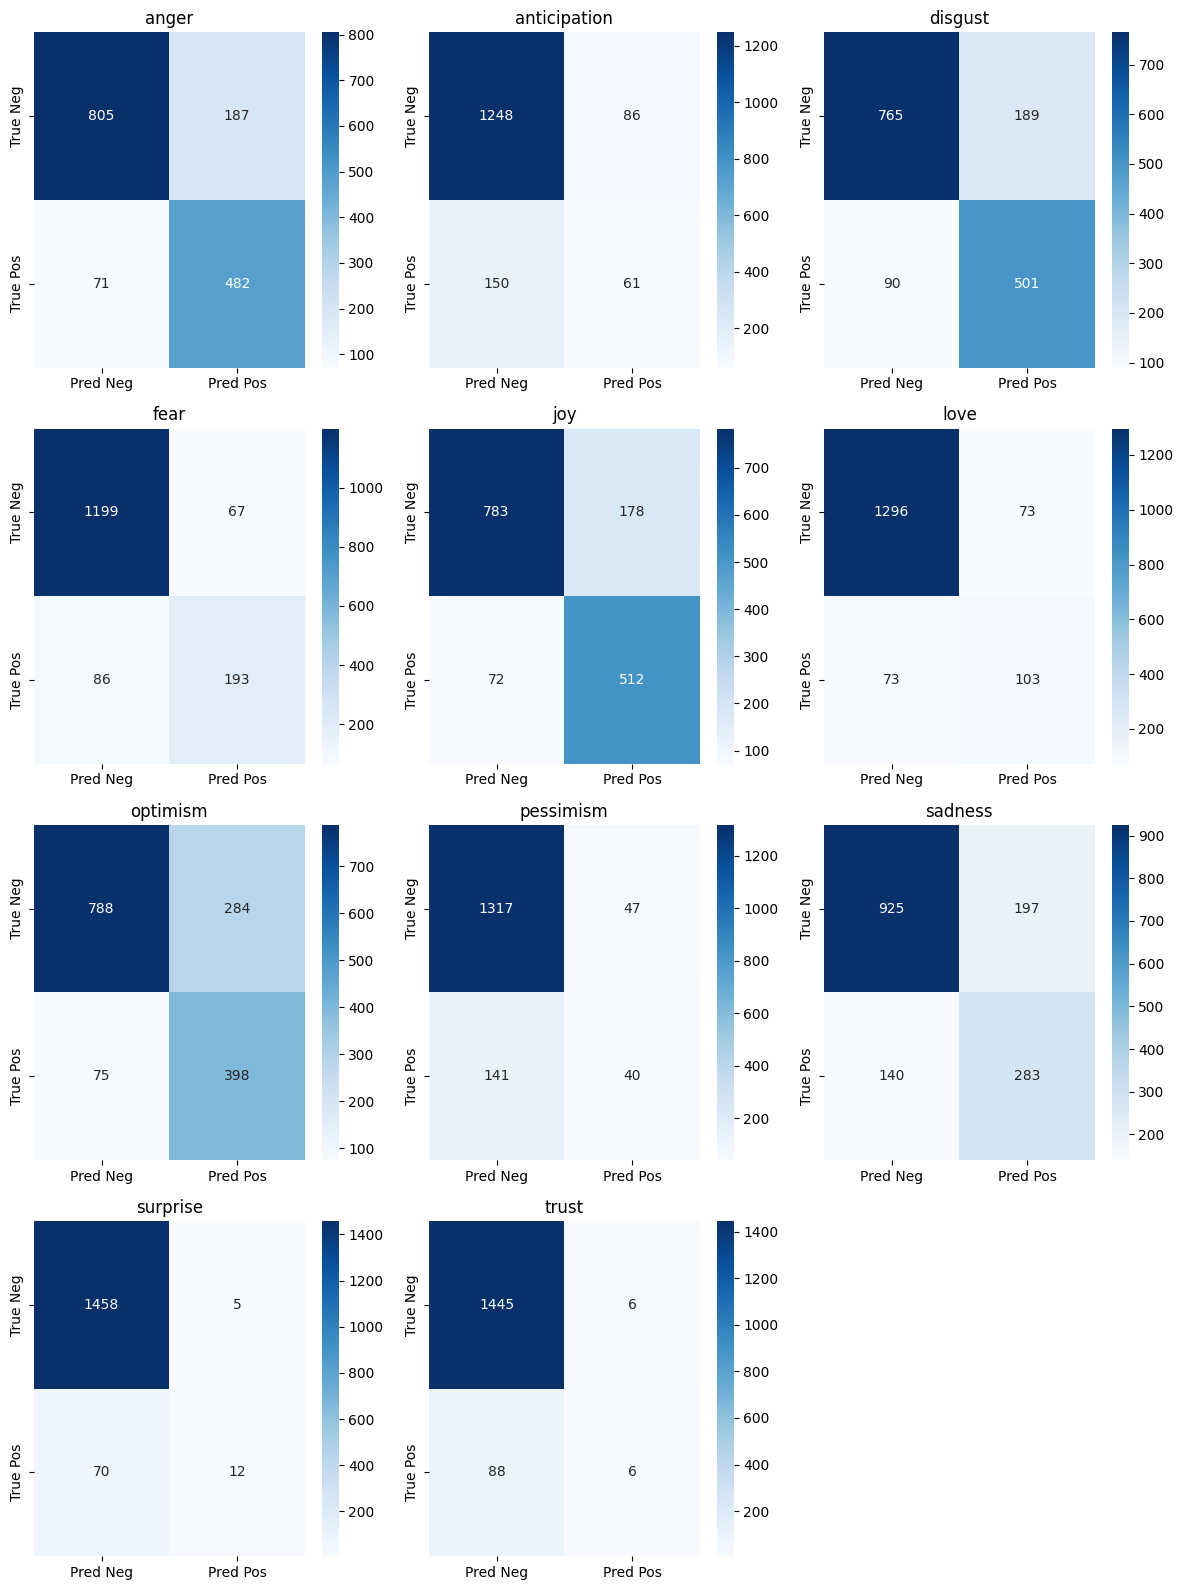

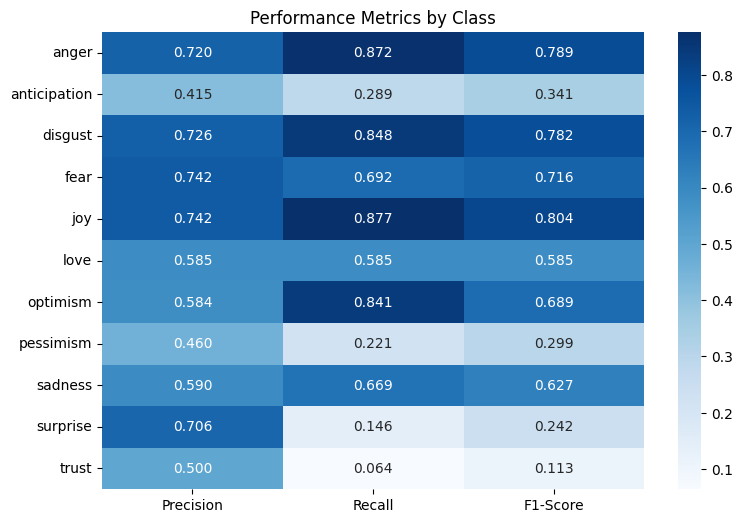

<Figure size 1200x533.333 with 0 Axes>

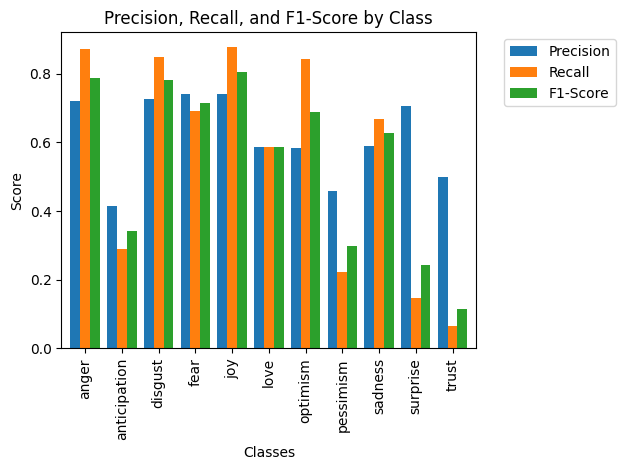

{'macro_avg': {'precision': 0.6154462484677281,
  'recall': 0.5548867845491261,
  'f1': 0.5442824059822615},
 'per_class': {'Precision': {'anger': 0.7204783258594918,
   'anticipation': 0.41496598639455784,
   'disgust': 0.7260869565217392,
   'fear': 0.7423076923076923,
   'joy': 0.7420289855072464,
   'love': 0.5852272727272727,
   'optimism': 0.5835777126099707,
   'pessimism': 0.45977011494252873,
   'sadness': 0.5895833333333333,
   'surprise': 0.7058823529411765,
   'trust': 0.5},
  'Recall': {'anger': 0.8716094032549728,
   'anticipation': 0.2890995260663507,
   'disgust': 0.8477157360406091,
   'fear': 0.6917562724014337,
   'joy': 0.8767123287671232,
   'love': 0.5852272727272727,
   'optimism': 0.8414376321353065,
   'pessimism': 0.22099447513812154,
   'sadness': 0.6690307328605201,
   'surprise': 0.14634146341463414,
   'trust': 0.06382978723404255},
  'F1-Score': {'anger': 0.7888707037643208,
   'anticipation': 0.3407821229050279,
   'disgust': 0.7822014051522248,
   'fear

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

#  <font color = 'indianred'> **8. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:

In [ ]:
test_dataset = data_folder/'test.csv'

In [ ]:
test_dataset = load_dataset('csv', data_files={'test': str(data_folder / 'test.csv')})['test']

In [ ]:
test_dataset

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 3259
})

In [ ]:
# Select only the 'Tweet' column and rename it to 'text'
test_set = test_dataset.map(lambda x: {"text": x["Tweet"]}, remove_columns=test_dataset.column_names)

# Verify the updated dataset
print(test_dataset)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
    num_rows: 3259
})


In [ ]:
test_set

Dataset({
    features: ['text'],
    num_rows: 3259
})

In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
test_inference_results = run_inference(seed = 42,
              dataset=test_set,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'test_complete_generations_llama')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 82/82 [02:00<00:00,  1.47s/it]


Saved inference_results to: /content/drive/MyDrive/Data/Models/Emotion_detection_Llama_languagehead_fall_2024/test_complete_generations_llama.json


In [ ]:
file_name = model_folder/'test_complete_generations_llama.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [ ]:
# Get predictions using our pipeline
# First extract content from model outputs
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results
]

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in test_extracted_outputs
]

print("Sample of predictions:", test_predictions[:10])

Sample of predictions: [['anger', 'disgust', 'fear'], ['anger', 'disgust', 'fear'], ['anger', 'disgust', 'sadness'], ['anticipation', 'sadness'], ['fear', 'sadness'], ['anger', 'disgust', 'fear'], ['joy', 'optimism'], ['joy', 'love', 'optimism'], ['joy', 'love', 'optimism'], ['pessimism', 'sadness']]


In [ ]:
# Extract IDs from the test dataset
test_ids = test_dataset['ID']  # Replace 'ID' with the column name in your dataset that contains IDs

# Map predictions to binary format
binary_predictions = []
for prediction in test_predictions:
    binary_row = [1 if label in prediction else 0 for label in class_names]
    binary_predictions.append(binary_row)

# Create a DataFrame
Output_df = pd.DataFrame(binary_predictions, columns=class_names)
Output_df.insert(0, "ID", test_ids)  # Add ID column from test dataset

# Save to CSV
output_file = "test_predictions_with_ids.csv"
Output_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

# Display the DataFrame
print(Output_df.head())

Predictions saved to test_predictions_with_ids.csv
           ID  anger  anticipation  disgust  fear  joy  love  optimism  \
0  2018-01559      1             0        1     1    0     0         0   
1  2018-03739      1             0        1     1    0     0         0   
2  2018-00385      1             0        1     0    0     0         0   
3  2018-03001      0             1        0     0    0     0         0   
4  2018-01988      0             0        0     1    0     0         0   

   pessimism  sadness  surprise  trust  
0          0        0         0      0  
1          0        0         0      0  
2          0        1         0      0  
3          0        1         0      0  
4          0        1         0      0  
